In [ ]:
import os
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#当调用的py文件修改时，可以用这个命令来更新调用的py文件
%load_ext autoreload
%autoreload 2

导入数据

In [ ]:
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f, encoding='latin1')
        X = dataset['data']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = dataset['labels']
        Y = np.array(Y)
    return X, Y

path = '../cs231n/datasets/cifar-10-batches-py'
xs = []
ys = []
for i in range(1,6):
    filename_train = os.path.join(path, 'data_batch_%d' % (i, ))
    X, Y = load_CIFAR_batch(filename_train)
    xs.append(X)
    ys.append(Y)
Xtr = np.concatenate(xs)
Ytr = np.concatenate(ys)
filename_test = os.path.join(path, 'test_batch')
Xtest, Ytest = load_CIFAR_batch(filename_test)
print(Xtr.dtype)

画出图片图像

In [13]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def plot(Xtr, Ytr, classes): 
    num_classes = len(classes)
    num_colum = 7
    for id, name in enumerate(classes):
        idx_total = np.where(Ytr == id)[0]
        idx_radom = np.random.choice(idx_total, num_colum)
        for i, idx in enumerate(idx_radom):
            index = num_classes * i + id + 1   #name类别的图像在整副图像中的位置
            plt.subplot(num_classes, num_classes, index)
            plt.imshow(Xtr[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(name)
    plt.show()

#测试函数功能
# plot(Xtr, Ytr, classes)

进行KNN训练

In [14]:
#选小部分数据减少运行时间
mask = 5000
Xtr = Xtr[range(mask)]
Xtr = np.reshape(Xtr, (Xtr.shape[0], -1))
Ytr = Ytr[range(mask)]
mask = 500
Xtest = Xtest[range(mask)]
Xtest = np.reshape(Xtest, (Xtest.shape[0], -1))
Ytest = Ytest[range(mask)]

In [15]:
from classifiers.K_Nearest_neighbor import KNearestNeighbor
classifiers_my = KNearestNeighbor()
classifiers_my.train(Xtr, Ytr)
dists = classifiers_my.compute_distances_no_loops(Xtest)
print(dists)

[[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434
  4203.28086142 4354.20256764]
 [6336.83367306 5270.28006846 4040.63608854 ... 4829.15334194
  4694.09767687 7768.33347636]
 [5224.83913628 4250.64289255 3773.94581307 ... 3766.81549853
  4464.99921613 6353.57190878]
 ...
 [5366.93534524 5062.8772452  6361.85774755 ... 5126.56824786
  4537.30613911 5920.94156364]
 [3671.92919322 3858.60765044 4846.88157479 ... 3521.04515734
  3182.3673578  4448.65305458]
 [6960.92443573 6083.71366848 6338.13442584 ... 6083.55504619
  4128.24744898 8041.05223214]]


开始进行预测

In [16]:
pre_Y = classifiers_my.predict(dists, k= 1)
accuracy = np.sum((pre_Y == Ytest)) / pre_Y.shape[0]
print('当k=1时K Nearest Neighbor算法的准确率为%d / %d correct => accuracy: %f' % (np.sum((pre_Y == Ytest)), pre_Y.shape[0], accuracy))

pre_Y = classifiers_my.predict(dists, k= 10)
accuracy = np.sum((pre_Y == Ytest)) / pre_Y.shape[0]
print('当k=10时K Nearest Neighbor算法的准确率为%d / %d correct => accuracy: %f' % (np.sum((pre_Y == Ytest)), pre_Y.shape[0], accuracy))

当k=1时K Nearest Neighbor算法的准确率为137 / 500 correct => accuracy: 0.274000
当k=10时K Nearest Neighbor算法的准确率为141 / 500 correct => accuracy: 0.282000


Cross validation

In [17]:
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
num_fold = 5
X_train_folds = np.array_split(Xtr, num_fold)
Y_train_folds = np.array_split(Ytr, num_fold)
k_to_accuracies = {}
for k in k_choices:
    for n in range(num_fold):
        current_train_fold_x = []
        current_train_fold_y = []
        for i in range(num_fold):
            if i != n:
                current_train_fold_x = np.append(current_train_fold_x, X_train_folds[i])
                current_train_fold_y = np.append(current_train_fold_y, Y_train_folds[i])
        current_train_fold_x = current_train_fold_x.reshape(((num_fold - 1) * X_train_folds[0].shape[0], X_train_folds[0].shape[1]))
        current_train_fold_y = current_train_fold_y.reshape(((num_fold - 1) * Y_train_folds[0].shape[0], ))
        current_test_fold_x = X_train_folds[n]
        current_test_fold_y = Y_train_folds[n]
        classifiers = KNearestNeighbor()
        classifiers.train(current_train_fold_x, current_train_fold_y)
        dis_current = classifiers.compute_distances_no_loops(current_test_fold_x)
        pre_current = classifiers.predict(dis_current, k)
        num_correct = np.sum(pre_current == current_test_fold_y)
        if k not in k_to_accuracies:
            k_to_accuracies[k] = [float(num_correct) / current_test_fold_x.shape[0]]
        else:
            k_to_accuracies[k].append(float(num_correct) / current_test_fold_x.shape[0])
            
#打印准确率函数
for key in k_to_accuracies:
    for values in k_to_accuracies[key]:
         print('k = %d, accuracy = %f' % (key, values))
        

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

画图

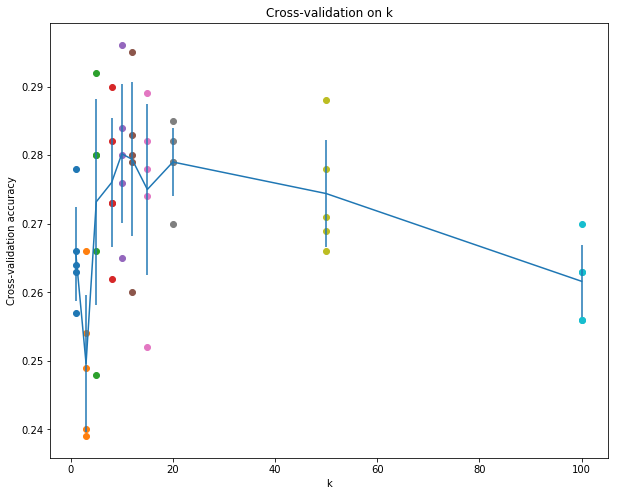

In [18]:
for k in k_choices:
    plt.scatter([k] * len(k_to_accuracies[k]), k_to_accuracies[k])

accuracy_mean = []
accuracy_std = []
for key in sorted(k_to_accuracies.keys()):
    accuracy_mean.append(np.mean(k_to_accuracies[key]))
    accuracy_std.append(np.std(k_to_accuracies[key]))
plt.errorbar(k_choices, accuracy_mean, yerr= accuracy_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

在test数据集上进行预测，求得模型准确率

In [19]:
best_K = 8
classifiers_test = KNearestNeighbor()
classifiers_test.train(Xtest, Ytest)
dists_test = classifiers_test.compute_distances_no_loops(Xtest)
Ytest_pre = classifiers_test.predict(dists_test, best_K)
num_test = Xtest.shape[0]
num_correct_test = np.sum(Ytest == Ytest_pre)
accuracy_test = num_correct_test / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct_test, num_test, accuracy_test))

Got 176 / 500 correct => accuracy: 0.352000


将分类结果进行可视化

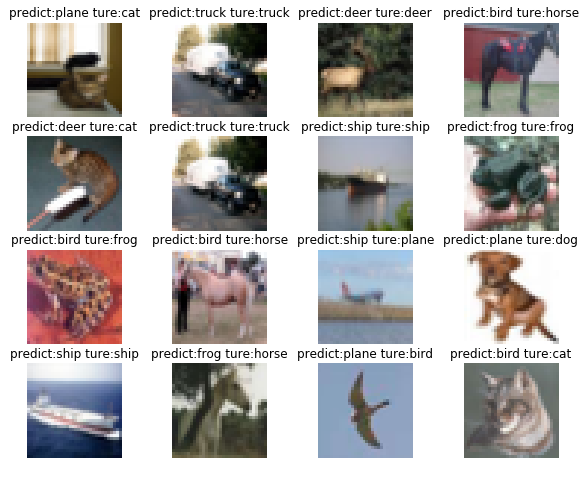

In [33]:
num_pic = 16
size = int(np.sqrt(num_pic)) 
name_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

test_random_index = np.random.choice(range(Xtest.shape[0]), num_pic)
Xtest_random = Xtest[test_random_index]
Xtest_random = Xtest_random.reshape((num_pic, 32, 32, 3))
Ytest_random = Ytest[test_random_index]
preYtest_random = Ytest_pre[test_random_index]
for i in range(size):
    for j in range(size):
        index = size * i + j
        plt.subplot(size, size, index + 1)
        plt.imshow(Xtest_random[index].astype('uint8'))
        plt.axis('off')
        plt.title('predict:%s ture:%s' % (name_classes[int(preYtest_random[index])], name_classes[int(Ytest_random[index])]))
plt.show()